<p align="Justify">
Here we shall create a model for classifying cifar10 dataset. As per instruction, our model is going to have an Autoencoder, which is gonna create a compressed  representation/feature vector for our classifier(Encoder part of the model). We can use the decoder part to evaluate performance of the Autoencoder itself.

Condition for dataset is as follows:
1. 50% data to be used from the following classes. (bird, deer,truck). 
2. No restriction on the rest of the classes.
</p>

# A short note on Autoencoder and Classifier Combination

<p>
An Autoencoder is an special type of neural network. in short, it tries to learn it's input by replicating it. It has two parts, one encoder part, which basically reduces the input data dimension and creates a compressed representation. The decoder part then expands it and produces the output. <BR/>
A classifier is well, what it's name implies, a machine learning algorithm that classifies stuff. In our case, its a neural network. Instead of using a stanalone convolutional neural network, we are taking the compressed representation from our autoencoder and feeding it to our classifier.
</p>

# The data and data stripping requirement

<p>
We are working on a quite well known dataset called the cifar-10. It's a dataset with 10 classes and 5000 images per class for training and 1000 images per class for test. 
The data distribution is shown below along with class names: 
</p>

![title](imgs/ds_dist_100.png)

The Task requirement states that the following classes are stripped of 50% of their sample data.
<ul>
    <li>Bird</li>
    <li>Deer</li>
    <li>Truck</li>
</ul>

![title](imgs/ds_dist_stripped.png)

We shall be importing some libraries to show model structures etc.

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

def print_model(model_name):
    with tf.device('/cpu:0'):
        model=load_model(model_name)
        return plot_model(model,show_shapes=True, show_layer_names=True)

# Problem breakdown and strategy

This problem is an unbalanced dataset problem. So careful selection of metric is an essential thing here.<BR/>
Our dataset has 10 classes, with 5000 samples per class. if we discard 50% image from 3 of our classes, we still have 7 classes. So even if we get all of samples from those 3 classes wrong, we can still get up to 82% accuracy(70% if we had 5000 images per class for those 3 classes). So accuracy can only provide a very high level overview, not the complete picture.<BR/>
Therefore, we shall include <B>precision, recall and F1 score</B> to our metrics. after each training, we shall also print a heatmap to see confusion matrix in percentage form.

# Loss function considerations

<p>
We have two different type of output here. One output will be an image of same size, since we have an autoencoder. Another is a one hot encoded categorical output. For the categorical output, its fairly simple. We are simply using <I>"Categorical Crossentropy"</I>. <BR/><BR/>
For the autoencoder however, it's slightly tricky. <BR/><BR/>
before feeding the image into network, we normalize it. So 8 bit RGB representation turns into a 32bit floating point representation where each pixel has value of 0-1 for each channel. This is to ease up the convergence of neural network. <BR/><BR/>For Autoencoders, usually<B> input data = output data</B><BR/><BR/>
So our output will also be an image of same size and channels as input,having 3 channels per pixel and floating point value between 0 and 1 per channel. The output layer can be set to sigmoid to make sure it is always between 0 and 1. The loss function can be either: <BR/>
    <ul>
        <li>Binary crossentropy - to consider it as a pixelwise classification problem</li>
        <li>Mean Square Error/Mean Absolute Error - To consider it as a regression problem.</li>
    </ul>
Binary crossentropy is not going to be a very good loss function for this problem. Because:
     <ul>
        <li>It's not a simple binary pixel problem like mnist -where value is 0 or 1.</li>
        <li> Each of the pixels have their own intensity levels. So its a regression problem.</li>
    </ul>
So I chose <I>"mse(mean squared error)"</I>. 
</p>

# Data split

80% train data and 20% hold out validation data with a fixed random state for reproducibility.

# Network

<B>I am using keras for creation and training of model</B>.<BR/><BR/>
Cifar-10 is a very well known dataset with plenty of tutorials and research papers on it. So instead of playing with every single parameter and making own network from absolute scratch, I decided to check existing classifier models/blocks as starting point and then tweak things by observing scores and losses.<BR/>
Cifar-10 images are quite small. Only 32x32x3. So pretrained models like VGG16/19 or inception V3 cannot be used directly as the bottleneck features would wither be too small or would result in errors due to negative output size etc.But we can be creative. Such as using VGG like blocks etc.
<BR/>
I have tried numerous tuning of epochs, hyperparameters and overfit prevention techniques. Out of all of them, I shall only describe a chosen few. Here are my networks:

# Training Strategy

<p>
To get good result and prevent overfitting, good training strategy is also important.<BR/>
At first with the first network, we train it in two ways.<BR/>
 <ul>
     <li>Train Autoencoder First, then train the classifier using the encoder output</li>
     <li>Combine both into one network and train</li>
 </ul>
For <B>batch size</B>, I experimented with different values. I happen to have a decent GPU, so I decided to use batch size of <B>256</B>. As larger batch sizes often help with generalization.<BR/>
For <B>epoch</B>, I initially set epoch values lower than 100. But after several testing and training metric analysis, I decided that a higher epoch may ensure a better change of convergence/reaching close to global minima. So i set it to <B>300</B>.<BR/>
But such a high number of epochs would be a problem without some kind of stopping system. So I put <B>EarlyStopping</B> callback with enough patience to prevent premature halting but small enough not to cause unnecessary timeloss.<BR/>
I also used <B>ReduceLRonPlateau</B> callback. I used it to drop learning rate when the convergence halts. This callback proved to be very useful.
For optimizer, I did not experiment a lot and just set <B>Adam</B>.<BR/>
For metrics, I just used loss for autoencoder and accuracy for classifier. But for things like ModelCheckpoint,early stopping and ReduceLRonPlateau, I used <B>validation loss</B> as metric as it provides more useful information than accuracy for example.
</p>

# Network 1 

This network's concept was taken from a paper titled <A href="https://arxiv.org/abs/1412.6806">Striving for simplicity: The all convolutional Net</A>. I only took some of the basic structure and filter concepts. The network structure will be shown in both separate and Autoencoder+classifier format.

<H3>Autoencoder</H3>

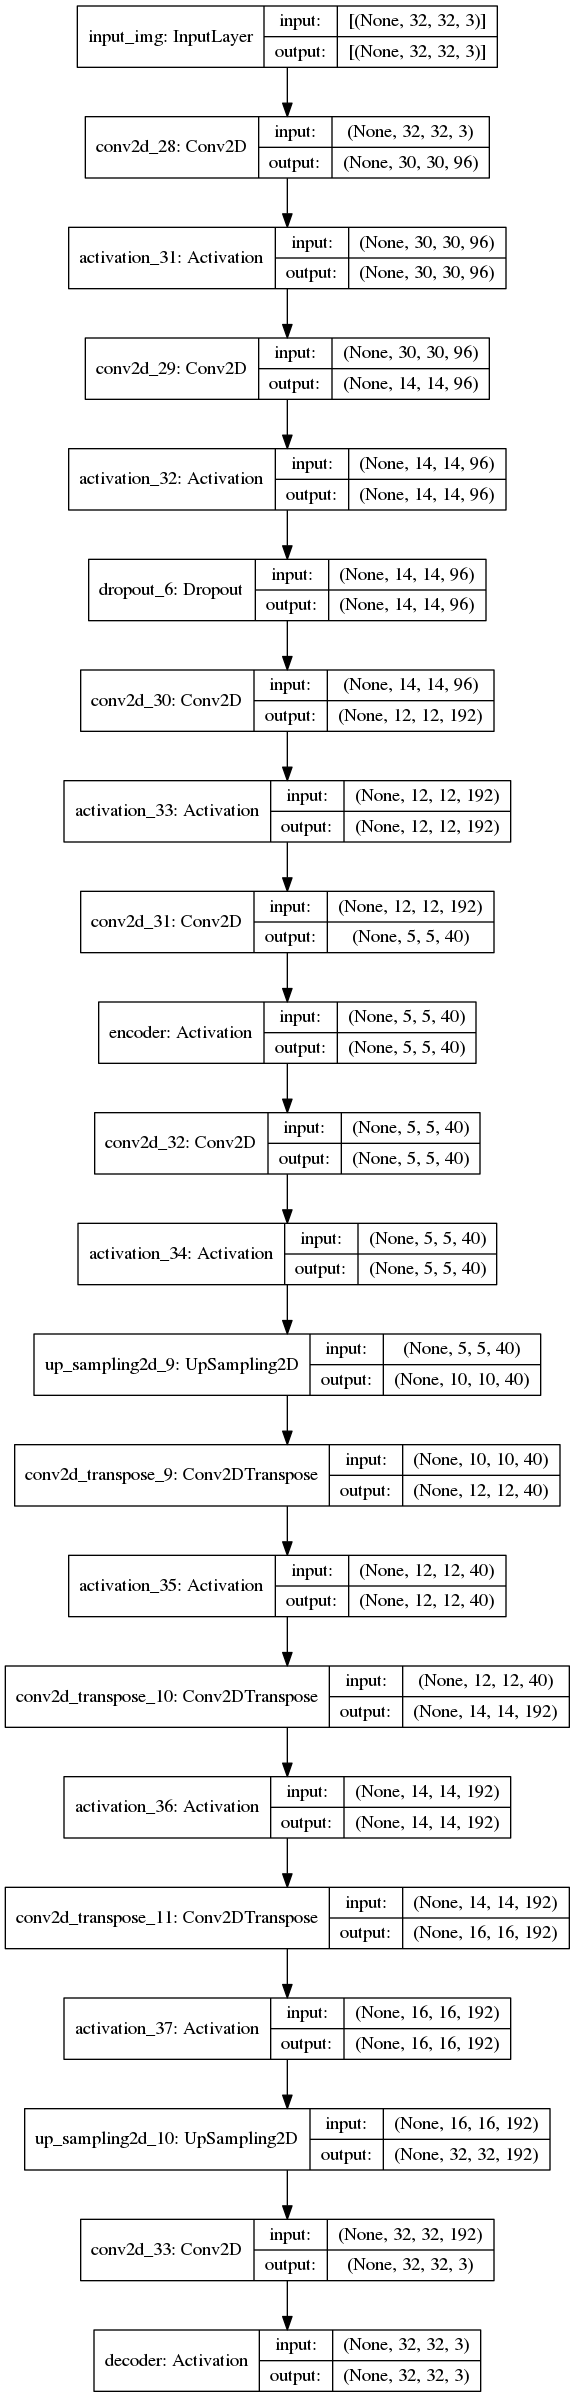

In [7]:
print_model("baseline_strip_no_aug_separate_AE.hdf5")

# Classifier

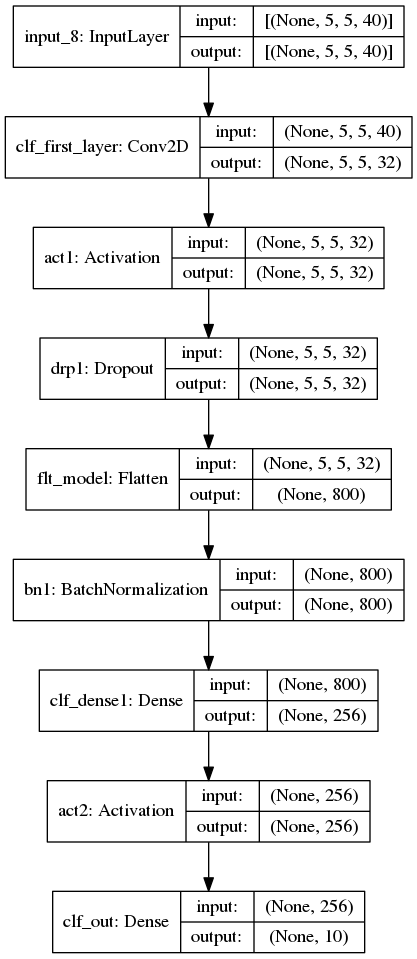

In [10]:
print_model("baseline_strip_no_aug_separate_CLF.hdf5")

# Combined

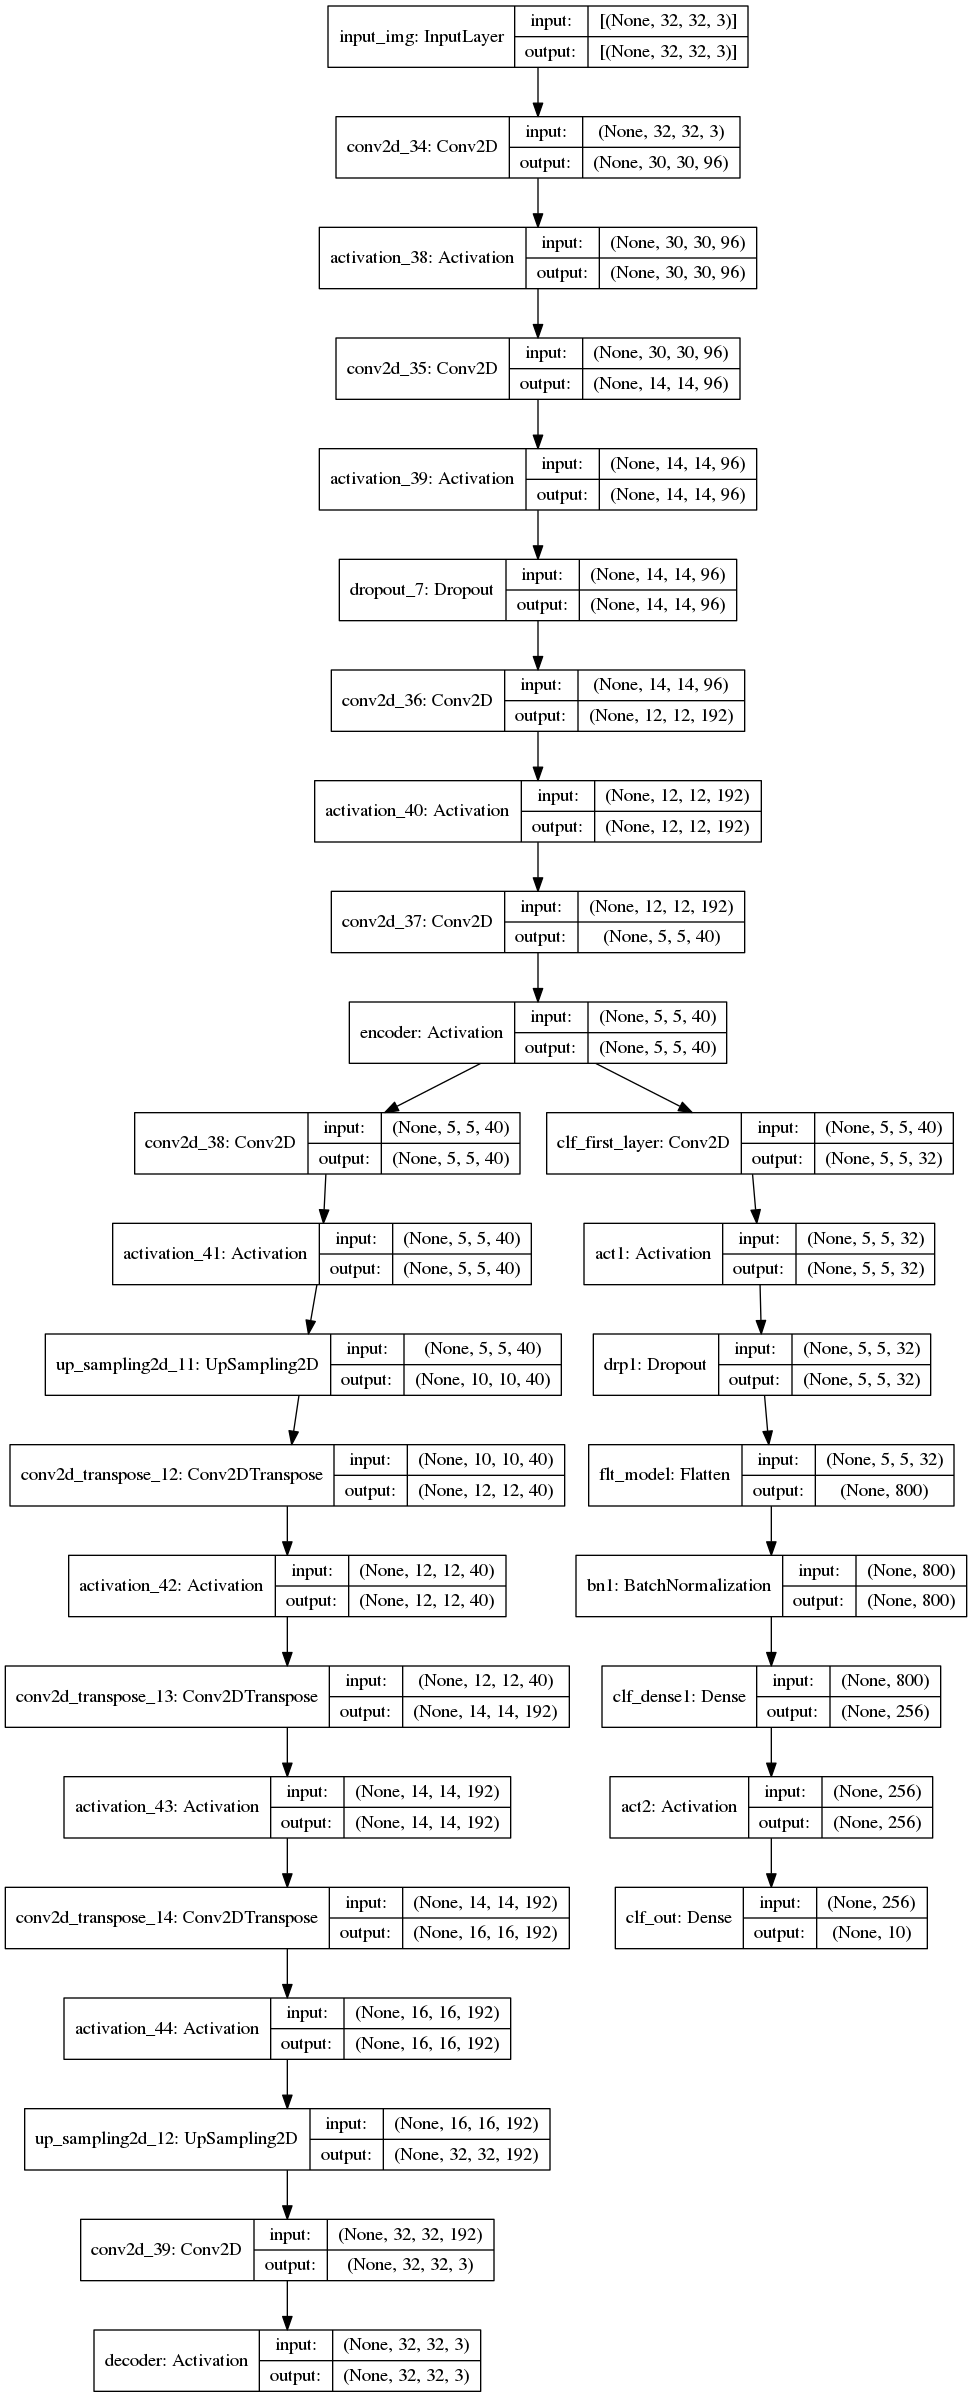

In [11]:
print_model("baseline_strip_no_aug_combined_COMB.hdf5")

<H3>Separate training - no augmentation</H3>

Here are the output graphs for separate training:

<B>Classification Report - Precision, Accuracy and F1 score</B>

So result does not look very good. For our imbalanced classes(bird,deer and truck), recall looks too poor. Let's also print the training graphs.

![title](imgs/separate_train_curve.png)

Autoencoder curve looks really good. Let's also print the classifer curve

![title](imgs/separate_train_curve2.png)

there seems to be some overfitting there. Let's look at the training evaluation data and graphs for single model now

<H3>Combined model training - no augmentation</H3>

<B>Classification Report</B>

Here accuracy is significantly higher. Even though it does not tell us the entire story. But the classification report tells us a lot. All of the classes show a significant performance boost. Precision and recall have increased a lot for our imbalanced classes as well. <BR/><B>Precision: 0.58 to 0.7 for bird, 0.55 to 0.69 for deer and 0.64 to 0.8 for truck.</B> <BR/>
<B>Recall: 0.27 to 0.4 for bird, 0.36 to 0.58 for deer and 0.51 to 0.82 for truck.</B> <BR/>


Score of truck is definitely quite abnormal. It should be low as it has less data and there is no augmentation.

Let's see some graphs for combined training.

![title](imgs/combined_train_curve_together.png)

This graph represents the combined loss of both autoencoder and classifier. We still see the overfitting phenomenon. But both losses have been reduces significantly. Let's see each of the losses induvidually.

<H3>Autoencoder loss</H3>

![title](imgs/combined_train_curve_ae_1.png)

That's kind of strange. The loss is higher than separately trained case. Let's see the classifier loss curve 

![title](imgs/combined_train_curve_clf.png)

It has improved quite a bit. But overfitting phenomenon is quite visible. <BR/>
Now, let's compare both training methods using a confusion matrix heatmap.

![title](imgs/model_1separate_combined_1.png)

<CENTER><B>Left one is separately trained classifier and Right one is combined.</B></CENTER><BR/>
This basically shows the recall curve for separately trained classifier and combined trained classifier. Here we are showing true positive labels on y axis and predicted ones at x axis. So the numbers on the diagonal line shows percentage of correctly predicted labels.

<B>So training together increases classification accuracy quite a bit </B> 

But what happens to the autoencoder part? Let's check out performance of autoencoder network trained separately and combined with classifier.

![title](imgs/eval_ae_1.png)

Well, this is what the loss values implied. seperately trained autoencoders are very good at matching corresponding input images. But autoencoders trained together with classifiers seem to do poorly at that. <BR/>
As per our assignment task, I think classifier performance matters more here. So, considering that, we shall use the "training together" approach for our next approaches.<BR/>
Obviously we can try to improve accuracy of the classifier for separately trained models by tweaking the classifier part.

<H3>Some approaches to stop overfitting</H3>
I tried several approaches for that.<BR/>
<ul>
    <li>Change classifier architecture such as dropping almost all of the classifier layers and just keep a flatten and softmax layer</li>
    <li>Add BatchNormalization</li>
    <li>Tweak Dropout layers, Dense layer etc.</li>
</ul>
But nothing improved the accuracy much. So I thought it was the effect of insufficient dataset. So I decided to perform augmentation.

# Augmentation

Augmentation is slightly tricky for this specific task. Because here, we are working with a multi output network where one output is the input itself.  Unfortunately the generator class's <B>flow</B> function is quite bare metal and can only output an (x,y) pair. But our desired output is (x,[x,y]) where the inner parentheses indicate output. Plus we also have imbalanced data to deal with.
Therefore, I decided to use imblearn library's balanced_batch_generator function. A custom generator function was written to feed the network properly formatted data.

# Results for network 1

It resulted in significant improvement and I was able to cross 80% quite easily even with Network 1 .Let's look at the Classification report first.

Each and every single score is considerable higher than no augmentation approaches. Let's see the recall heatmap

![title](imgs/model_1separate_combined_2.png)

As we can see, 6 of the classes have more than 80% recall. Our imbalanced classes(bird,deer and truck) have significantly improved(all over 75% and truck being 87%). But a suspicious find is the class cat which is, despite having 100% data, still being very highly misclassified, mostly as dog. A possible explanation is that the images are too small so cats are being misclassified as dog as these are the most similar classes among the 10 classes. In fact, the class cat is the only class that has a recall value below 75%.

Let's see the loss curves:

![title](imgs/aug_img_comb1.png)

Well, both losses have certainly gone lower. But we still can see that validation loss stops improving close to epoch 60. Thats where we probably got our best model. Let's also see the individual loss graphs.

![title](imgs/aug_img_comb1_ae.png)

Validation loss for autoencoder has certainly gone down. But the gap between them have somehow increased.

![title](imgs/aug_img_comb1_clf.png)

Classifier loss graph shows good improvement over non augmented dataset. For reference, let's compare:
![alt](imgs/combined_train_curve_clf.png) | ![alt](imgs/aug_img_comb1_clf.png)

In case of non augmented data, the validation loss actually started to drift away from training loss after 10 epochs. 

<H3>Summary for network 1</H3>

We saw that augmentation helped the model learn the data a lot and it reduced overfitting tendency. But after that, I tried several network tweaks, none of which showed any change outside the margin of uncertainly of GPU training.

# Network 2

This time, I decided to try to VGG like architecture. From my work experience, I have seen that VGG16 can sometimes achieve really good scores for image categories it was never even trained(Can't say much as it was found in one of my company projects). 
<BR/>
But VGG16 or VGG19 are originally made for significantly larger images(224x224 was it's original training image dimension. Image size is usually set to 224x224 for training on VGG). So we cannot use it directly without modification. Plus it's quite a big network which may overfit swiftly. <BR/>
This network contains three VGG like blocks. After seeing overfitting tendencies in numerous trial and error based attempts, kernel regularizers were added to each convolution block and BatchNormalization was also used. Another difference with previous model is that I Flattened the encoder layer before feeding it into the classifier.<BR/>
Till now I was using ReLU as the activation function for internal layers. After some online study, I decided to use ELU activation as it does not have the vanishing gradient problem. <BR/>

<H3>Network structure-combined</H3>

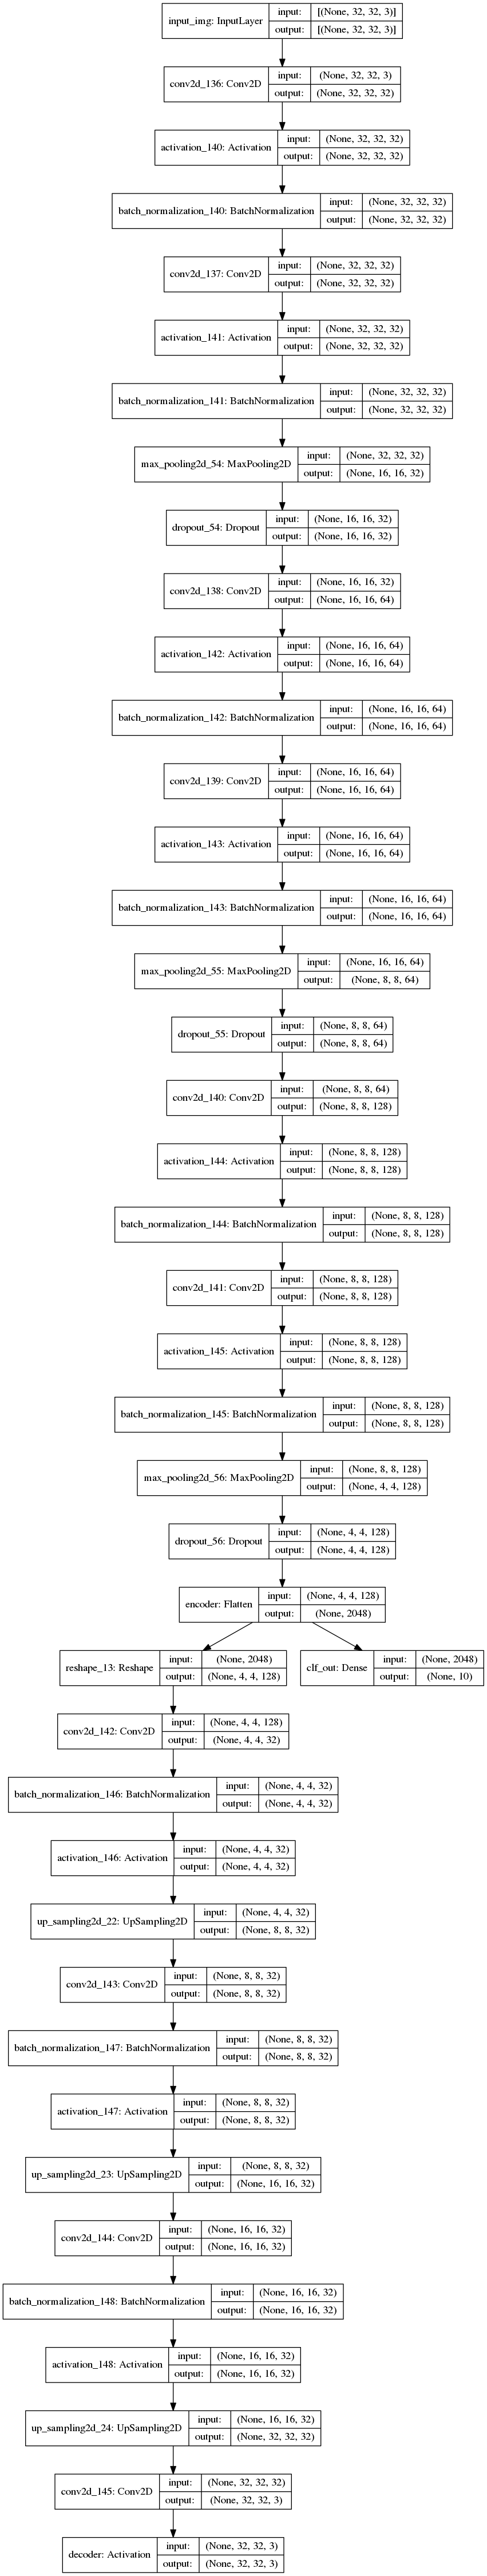

In [16]:
print_model("aug_combined_mod_COMB.hdf5")

Let's Look at the classification report

So, we achieved 88% accuracy and nearly all classes have precision and recall scores of more than 80%(class cat and bird being different, even though bird has very high precision). Let's look at recall matrix of both network 1 and 2(with augmentation)

![title](imgs/best_2_models.png)

<center><B>Left is network 1 and Right is network 2</B></center><BR/>
As we can see, network 2 shows very significant improvements in all classes. The training curves are shown below:

![title](imgs/aug_net2_comb.png)

we see that we are having some overfitting issue even though the model is performing very well.

<B>Autoencoder loss</B>

![title](imgs/aug_net2_ae.png)

Autoencoder shows some really interesting trend. There is a strange dip at the very beginning and then high oscillation in validation loss.

<B>Classifier loss</B>

![title](imgs/aug_net2_clf.png)

Classifier is back with that overfitting issue. validation loss is lower than network 1 but there is still overfit.

# Comparing Autoencoder performance of augmented Network1 and 2

![title](imgs/aug_ae_comb.png)

Here we can see that, the better the classifier is, the worse the autoencoder becomes. The reason is quite unclear. The model is somehow getting biased towards classification?
<B>lossWeights does not seem to improve this situation much</B>

# Overall findings and discussion

<ul>
    <li>Training separately seems to improve Autoencoder performance . But it worsens classifier accuracy. So after initial attempt, I switched to combined training. Because our goal is to improve classification accuracy.</li>
    <li>Combined training seems to worsen autoencoder performance, but it improves classification accuracy a lot. May be training together balances the encoder weights for both classification and image generation.</li>
    <li>Augmentation provided a significant boost in accuracy. Imblearn's balanced_batch_generator seems to be working well.</li>
    <li>VGG-like convolution and pooling blocks perform really well.</li>
    <li>Data augmentation reduced overfitting quite well.</li>
    <li>the class "Cat" seems to be the worst scoring class. Despite having 100% data, it consistently scored worst or close to worst. Since cat and dog are quite similar classes, probably the model somehow got biased towards the class Dog.</li>
    <li>The better the classifier is,the worse the autoencoder becomes.</li>
</ul>